# Opxの累帯構造をコンパイルしモデル累帯構造を作成する

それぞれのOpxの分析値は，結晶方位によって異なる拡散係数のもとでの元素拡散で改変されている．

したがって，そのまま重ね合わせた場合，元素拡散の程度の違うプロファイルを統合してしまう．

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 

from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

import bokeh.plotting as bplt
from bokeh.layouts import row, column, gridplot
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook, push_notebook
from IPython.display import display
import ipywidgets as widgets

%matplotlib inline
bplt.output_notebook()

%matplotlib inline

Loading BokehJS ...

## Elastic network modelによる組成不連続点の検出

Lasso回帰とRidge回帰の線形結合

$$
    \lambda \sum^m_{j=1}\left( a|w_j| + (1-a)w_j^2 \right)
$$

ラグランジュの未定定数法で

$$
    \sum^N_{i=1}\left(y_i - \sum^p_{j=1}\beta_j x_i^{(j)}\right)^2 + \lambda \sum^p_{j=1}\left( a|\beta_j| + (1-a)\beta_j^2 \right)
$$

この式を最小化する

このとき$\beta$の値は$x$に影響されるので, しばしば$\sqrt(\sum x^2) = 1$と規格化する

Fused lasso: データ数とパラメータ数が等しい. 隣り合うパラメータの差が小さくなるようにフィッティングを行う. 



$$
    \min\left[ \sum^N_{i=1}\left(y_i - \beta_i \right)^2 + \lambda \sum^{N-1}_{i=1}\left( |\beta_{j+1} - \beta_j| \right) \right]
$$

### 参考 [by using lightning library](http://contrib.scikit-learn.org/lightning/auto_examples/plot_1d_total_variation.html)

2017/11 現在, scikitlearnにはfused lassoのメソッドはない.
 パラメータ間の関係に関する行列の指定もできない.


### Python によるtrend filterの実装例

- [myl1tf](https://www.google.co.jp/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwjBqfbKzrvXAhWBpZQKHSNHAK0QFggnMAA&url=https%3A%2F%2Fpypi.python.org%2Fpypi%2Fmyl1tf%2F0.1&usg=AOvVaw0DqOcbiliGSJM3XMhCJvhS)
- [py-l1tf](https://www.google.co.jp/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&cad=rja&uact=8&ved=0ahUKEwjBqfbKzrvXAhWBpZQKHSNHAK0QFgguMAE&url=https%3A%2F%2Fgithub.com%2Felsonidoq%2Fpy-l1tf&usg=AOvVaw0GJyl_dy91EK4fvpF_PzNU)

In [2]:
from lightning.classification import FistaClassifier
from sklearn.grid_search import GridSearchCV



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [87]:
# ステップ関数のフィッティング

# generate some synthetic data
n_samples = 400

# テスト用のデータ
ground_truth = np.concatenate((
    np.ones(20), - np.zeros(20), np.ones(20), -np.ones(20)))
n_features = ground_truth.size
np.random.seed(0)  # for reproducibility

X = np.random.rand(n_samples, n_features)
# generate y as a linear model, y = sign(X w + noise)
y = np.sign(X.dot(ground_truth) + 0.5 * np.random.randn(n_samples)).astype(np.int)


x = X.dot(ground_truth)
#print("x",x)
print("ground_truth",ground_truth)
#print("y",y)
#print(len(y))
#print("X",X[0])
p = figure(title="test of fused lasso")
p.scatter([i for i in range(0,len(ground_truth))],ground_truth,legend="truth")
#p.scatter([i for i in range(0,len(x))],x,legend="X",color="red")


clf = FistaClassifier(penalty="tv1d",alpha=1, max_steps=50)
gs = GridSearchCV(clf, {'alpha': np.logspace(-3, 3, 10)})
gs.fit(X, y)
coefs = gs.best_estimator_.coef_
print(coefs)
p.line([i for i in range(0,len(coefs.ravel()))],coefs.ravel(), legend="fused lasso", color="red")


show(p)

ground_truth [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.]
[[-0.03306924 -0.02976887 -0.02939289 -0.03276813 -0.03062803 -0.03283482
  -0.03517814 -0.03279266 -0.03100184 -0.03225412 -0.03253724 -0.03354796
  -0.03490883 -0.03043512 -0.03131558 -0.03006613 -0.03084715 -0.03376583
  -0.0339153  -0.03526439 -0.03298736 -0.03676856 -0.03268112 -0.03220846
  -0.03330348 -0.03485893 -0.03179491 -0.03231408 -0.03665194 -0.03272017
  -0.0329287  -0.03251255 -0.03452241 -0.03489302 -0.02930191 -0.03152926
  -0.03480662 -0.03330419 -0.0331812  -0.03019816 -0.03313652 -0.03151766
  -0.03405314 -0.0329266  -0.02974551 -0.03405134 -0.034643   -0.03230292
  -0.03450785 -0.03257254 -0.03416722 -0.03150344 -0.03363089 -0.0315

In [64]:
# Saw tooth like

# generate some synthetic data
n_samples = 200

# テスト用のデータ
ground_truth = np.concatenate((
    np.array([2 for x in range(0,20)]), np.array([-2 for x in range(0,20)]), np.zeros(40)))
n_features = ground_truth.size
np.random.seed(0)  # for reproducibility

X = np.random.rand(n_samples, n_features)
# generate y as a linear model, y = sign(X w + noise)
y = np.sign(X.dot(ground_truth) + 0.5 * np.random.randn(n_samples)).astype(np.int)


x = X.dot(ground_truth)
#print("x",x)
print("ground_truth",ground_truth)
#print("y",y)
#print(len(y))
#print("X",X[0])
p = figure(title="test of fused lasso")
p.scatter([i for i in range(0,len(ground_truth))],ground_truth,legend="truth")
#p.scatter([i for i in range(0,len(x))],x,legend="X",color="red")


clf = FistaClassifier(penalty="tv1d")
gs = GridSearchCV(clf, {'alpha': np.logspace(-3, 3, 10)})
gs.fit(X, y)
coefs = gs.best_estimator_.coef_

p.line([i for i in range(0,len(coefs.ravel()))],coefs.ravel(), legend="fused lasso", color="red")

clf = FistaClassifier(penalty="l1")
gs = GridSearchCV(clf, {'alpha': np.logspace(-3, 3, 10)})
gs.fit(X, y)
coefs = gs.best_estimator_.coef_

p.line([i for i in range(0,len(coefs.ravel()))],coefs.ravel(), legend="l1", color="black")

show(p)

ground_truth [ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]


In [65]:
a = np.logspace(-3, 3, 10)
print(a)

[  1.00000000e-03   4.64158883e-03   2.15443469e-02   1.00000000e-01
   4.64158883e-01   2.15443469e+00   1.00000000e+01   4.64158883e+01
   2.15443469e+02   1.00000000e+03]


In [4]:
df = pd.read_csv("../data/SVB/mineral/EPMA/opx_zoning_compile.csv")

display(df.head(10))

sample = df.comment.unique()
sampleNum = len(sample)
print(sample,sampleNum)

,ID,date,No,SiO2,Al2O3,TiO2,FeO,MnO,MgO,CaO,...,Total,Phase,pos,comment,distanse,radius,Fe/Mg,Mg#,stage,cordinate
0,220,2013_0727,891,53.520,1.480,0.0,11.892,0.310,28.447,1.829,...,97.764,opx,6,1002-9-1A-4_Line1,24,-132,0.234624,80.996313,9.0,l
1,221,2013_0727,892,54.192,1.639,0.0,9.529,0.286,30.635,1.308,...,98.002,opx,7,1002-9-1A-4_Line1,28,-128,0.174576,85.137131,9.0,l
2,222,2013_0727,893,55.143,1.976,0.0,6.341,0.151,33.051,1.177,...,98.264,opx,8,1002-9-1A-4_Line1,32,-124,0.107678,90.278936,9.0,l
3,223,2013_0727,894,54.796,2.112,0.0,6.632,0.164,32.804,1.277,...,98.179,opx,9,1002-9-1A-4_Line1,36,-120,0.113468,89.809527,8.0,l
4,224,2013_0727,895,54.716,2.107,0.0,6.904,0.161,32.705,1.236,...,98.220,opx,10,1002-9-1A-4_Line1,40,-116,0.118479,89.407144,8.0,l
5,225,2013_0727,896,54.762,2.113,0.0,6.465,0.164,32.707,1.270,...,97.886,opx,11,1002-9-1A-4_Line1,44,-112,0.110938,90.013989,8.0,l
6,226,2013_0727,897,54.667,2.133,0.0,6.628,0.154,32.725,1.272,...,97.989,opx,12,1002-9-1A-4_Line1,48,-108,0.113673,89.792970,8.0,l
7,227,2013_0727,898,54.451,2.183,0.0,6.646,0.152,33.021,1.232,...,98.103,opx,13,1002-9-1A-4_Line1,52,-104,0.112960,89.850497,8.0,l
8,228,2013_0727,899,54.808,2.130,0.0,6.690,0.150,32.967,1.248,...,98.402,opx,14,1002-9-1A-4_Line1,56,-100,0.113894,89.775148,8.0,l
9,229,2013_0727,900,54.730,2.140,0.0,6.642,0.158,32.915,1.229,...,98.228,opx,15,1002-9-1A-4_Line1,60,-96,0.113255,89.826641,8.0,l


['1002-9-1A-4_Line1' '1002-9-1C-1_Line1' '1002-9-1D-2_Line1'
 '2013_0815_1002-9-1C-OpxOl-1' '2013_0815_1002-9-1C-OpxOl-2' '1002-9-1D-2'
 '1002-9-1D-Opx8-1' '1002-9-1D-Opx8-2'] 8


In [6]:
# comment列のgrain名によってデータを切り分け

def getOpxs(df):
    opx = {}
    for grain in sample:
        opx[grain] = df[df.comment == grain]
    return opx

# color map

def gen_cmap(colors):
    val = range(len(colors))
    vMax = np.ceil(np.max(val))
    color_list=[]
    for v,c in zip(val,colors):
        color_list.append((v/vMax,c))
    return LinearSegmentedColormap.from_list("custom_cmap",color_list)


# ステージごとに半径方向にノーマライズしてデータを統合

def getNormSection(opx,sample,stage,yName):

    stageNum = len(stage)
    print(stage)

    xName = "radius"
    optName = ["comment","cordinate"]

    normSection = {}
    for st in stage:
        normSection[str(st)] = {}
        normSection[str(st)][xName] = []
        for elem in yName:
            normSection[str(st)][elem] = []
        for opt in optName:
            normSection[str(st)][opt] = []
            

    for grain in sample:
        data = opx[grain]

    
        for st in stage:
            subR = data[(data.stage == st) & (data.cordinate == "r")]
            minR = subR.radius.min() 
            maxR = subR.radius.max()
            #print(grain,st,minR,maxR)
            if (maxR == minR):
                coeffR = 1
            else:
                coeffR = 1./(maxR - minR)
            #print(subR)
            if len(subR > 0):
                for key,row in subR.iterrows():
                    #print(row)
                    normSection[str(st)][xName].append( (row.radius - minR) * coeffR )
                    for elem in yName:
                        normSection[str(st)][elem].append(row[elem])
                    for opt in optName:
                        normSection[str(st)][opt].append(row[opt])
        
            subL = data[(data.stage == st) & (data.cordinate == "l")]
            minL = subL.radius.min() 
            maxL = subL.radius.max()
        
            if (maxL == minL):
                coeffL = 1
            else:
                coeffL = 1./(minL - maxL)
            #print(subL)
        
            if len(subL > 0):
                for key,row in subL.iterrows():
                    normSection[str(st)][xName].append( (row.radius - maxL) * coeffL )
                    for elem in yName:
                        normSection[str(st)][elem].append(row[elem])
                    for opt in optName:
                        normSection[str(st)][opt].append(row[opt])


    fig = plt.figure(figsize=(6*len(yName),6*stageNum),facecolor="white")

    i = 1




    for st in stage:
        data = normSection[str(st)]
        
        for y in yName:
    
            ax=fig.add_subplot(stageNum,len(yName),i)
            ax.set_title("stage "+str(st),fontsize=16)
            ax.tick_params(labelsize=14)
            ax.set_xlabel(xName,fontsize=16)
            ax.set_ylabel(y,fontsize=16)
            ax.set_ylim(plotRange[y])
            plt.scatter(data[xName],data[y],color="black")
            i=i+1
            
    return normSection


# 規格化した各ステージの移動平均と移動分散? を計算する
# 単純移動平均
# 規格化したプロファイルについて，区間0.2区間ごとの平均と不偏標準偏差を求める．
    # 区間ごとに不偏標準偏差は異なる

def moval(normSection,stage,yName):


    stageNum = len(stage)
    print(stage)

    xName = "radius"



    # 区間[0,1]をN+1個のグリッドに分割
    # グリッド点+-drの範囲に含まれるデータの平均と分散を求める

    N = 5
    dr = 1./N /2 # 半径方向刻み幅

    mean = {}
    stdev = {} # 不偏標準偏差


    for st in stage:
        data = normSection[str(st)]
        # print(data)
        mean[str(st)]={}
        stdev[str(st)]={}
    
    
    
    
        for y in yName:
            me = []
            sd = []
            radius = []
            for i in range(0,N):
                center = i/N + dr
            
            
                dataNum = 0
                sum1 = 0.
                sum2 = 0
            
                for r,c in zip(data["radius"],data[y]):
                    deltaR = abs(center-r)
                    if ( i == N-1):
                        if((center - dr <= r)&(r<=center+dr)):
                            sum1 = sum1 + c
                            sum2 = sum2 + c * c
                            dataNum = dataNum +1
                    else:
                        if ((center - dr <= r)&(r<center+dr)):
                            sum1 = sum1 + c
                            sum2 = sum2 + c * c
                            dataNum = dataNum +1
            
                if (dataNum > 1):
                    sum1 = sum1 / dataNum
            
                    me.append(sum1)
                
                    sd.append(np.sqrt((sum2/dataNum - sum1*sum1)*dataNum/(dataNum-1)))
                
                    radius.append(center)
                else:
                    print(st,"There is only one data")

        
            mean[str(st)][y]=np.array(me)
            stdev[str(st)][y]=np.array(sd)
                
        mean[str(st)]["radius"]=np.array(radius)
        stdev[str(st)]["radius"]=np.array(radius)

    
    fig = plt.figure(figsize=(6*len(yName),6*stageNum),facecolor="white")

    i = 1

    

    for st in stage:
        data = normSection[str(st)]
    
        for y in yName:

            ax=fig.add_subplot(stageNum,len(yName),i)
            ax.set_title("stage "+str(st),fontsize=16)
            ax.tick_params(labelsize=14)
            ax.set_xlabel(xName,fontsize=16)
            ax.set_ylabel(y,fontsize=16)
            ax.set_ylim(plotRange[y])
            ax.scatter(data[xName],data[y],color="black",s=10)
        
            ax.plot(mean[str(st)][xName],mean[str(st)][y],color="black",linewidth=1)
            ax.plot(stdev[str(st)][xName],(mean[str(st)][y] + stdev[str(st)][y]),color="black",linestyle="dashed",linewidth=1)
            ax.plot(stdev[str(st)][xName],mean[str(st)][y]-stdev[str(st)][y],color="black",linestyle="dashed",linewidth=1)
            i=i+1
            
    return {"mean":mean,"stdev":stdev}


# セグメントを5つのサブセグメントに分け，その中での移動平均に対する残差の総和を求め，プロファイル全体の不偏標準偏差を計算する
    # 全てのデータは同じ不確かさをもつことになる
def integratedMoval(normSection,stage,yName):
    stageNum = len(stage)
    print(stage)

    xName = "radius"



    # 区間[0,1]をN+1個のグリッドに分割
    # グリッド点+-drの範囲に含まれるデータの平均と分散を求める

    N = 5
    dr = 1./N /2 # 半径方向刻み幅

    stdev = {} # 不偏標準偏差
    
    
    

    for y in yName:
    
        dataNum = 0
        sum2 = 0
        
    
        for st in stage:
            data = normSection[str(st)]
            # print(data)
    
            # サブステージ
            for i in range(0,N):
                center = i/N + dr
            
                sum1 = 0.
                m = 0
                for r,c in zip(data["radius"],data[y]):
                    deltaR = abs(center-r)
                    if ( i == N-1):
                        if((center - dr <= r)&(r<=center+dr)):
                            sum1 = sum1 + c
                            m=m+1
                            dataNum = dataNum +1
                    else:
                        if ((center - dr <= r)&(r<center+dr)):
                            sum1 = sum1 + c
                            m=m+1
                            dataNum = dataNum +1
                            
                # サブステージ平均
                mean = sum1/m
                
                # サブステージごとに残差和
                for r,c in zip(data["radius"],data[y]):
                    deltaR = abs(center-r)
                    if ( i == N-1):
                        if((center - dr <= r)&(r<=center+dr)):
                            sum2 = sum2 + (c-mean)*(c-mean)
                            
                    else:
                        if ((center - dr <= r)&(r<center+dr)):
                            sum2 = sum2 + (c-mean)*(c-mean)
                

        

        
        stdev[y]=np.sqrt(sum2/(dataNum-1))
        
    return {"stdev":stdev}



# normSectionを実際のgrainのステージ幅をもとに変形
# サブセグメントごとに分散が異なる
def getDataForInversion(normSection,yName,stage,stageRadius,stdev,err=True):
    xName = "radius"
    data = {}
    radius = []
    st = []
    compo = {}
    cstdev = {}
    for y in yName:
        compo[y]=[]
        cstdev[y]=[]
    
    inner = 0.

    num =0
    num2=0
    for i in range(0,len(stage)):
        s = str(stage[i])
        outer = stageRadius[i]

        k=0
        for r in normSection[s]["radius"]:
            radius.append(r*(outer-inner)+inner)
            st.append(stage[i])

            
    
        for y in yName:
            for c in normSection[s][y]:
                compo[y].append(c)
    
        l = len(stdev[s]["radius"])
        #print(l)
        dr = 0.5/(len(stdev[s]["radius"]))
    
        for j in range(l):
            # print(j) #全てのデータが呼ばれている
            center = stdev[s]["radius"][j]
            for r in normSection[s]["radius"]:
                num2 = num2+1 # ここは全てのデータが呼ばれている
                # print(stdev[s]["radius"][j] -dr,stdev[s]["radius"][j] +dr)
                if (j == l-1 ):

                    if ((center -dr <= r) & (r <= center +dr)):
                        num = num+1
                        for y in yName:
                            cstdev[y].append(stdev[s][y][j])
                        
                    elif (stdev[s]["radius"][j]+dr < r):
                        print(r,"is out of range") # ここにかかるものはない
            
                elif (j == 0):
                    if ((center-dr <= r) & (r< center+dr+0.000001)):
                        num = num+1
                        for y in yName:
                            cstdev[y].append(stdev[s][y][j])
                    elif (r< stdev[s]["radius"][j]-dr):
                        print(r,"is out of range") # ここにかかるものはない
                
            
                else:
                    if ((center-dr <= r) & (r< center+dr)):
                        num = num+1
                        for y in yName:
                            cstdev[y].append(stdev[s][y][j])

                 
        inner = outer+1
                 
    data["radius"]=np.array(radius)
    data["stage"]=np.array(st)

    for y in yName:
        print(y,len(cstdev[y]))
        data[y]=np.array(compo[y])
        data[y+"_stdev"]=np.array(cstdev[y])

    print(num,num2/l)
    #print(normSection["1.0"]["radius"])
    #print(stdev["1.0"]["radius"])
    
    fig = plt.figure(figsize=(9*len(yName),6*2),facecolor="white")

    i = 1

    stageRange=[min(stage),max(stage)]

    for y in yName:
    
        ax=fig.add_subplot(2,len(yName),i)
        #ax.set_title(title,fontsize=16)
        ax.tick_params(labelsize=14)
        ax.set_xlabel("radius(μm)",fontsize=20)
        ax.set_ylabel(y,fontsize=20)
        ax.set_ylim(plotRange[y])
        #plt.scatter(data[xName],data[y],c=data["stage"],cmap = colorMap)
        if (err == True):
            plt.errorbar(data[xName],data[y],yerr=data[y+"_stdev"],ls="None",lw=0.4)
        plt.scatter(data[xName],data[y],color="black",s=2)
        
    
        for r in stageRadius:
            plt.plot([r,r],[-100,100],color="gray",linewidth="0.5")
    
        #ax=plt.colorbar()
        #ax.set_clim(stageRange)
        i=i+1
    
    ax=fig.add_subplot(2,len(yName),i)
    #ax.set_title(title,fontsize=16)
    ax.tick_params(labelsize=14)
    ax.set_xlabel("radius(μm)",fontsize=20)
    ax.set_ylabel("Mg#",fontsize=20)
    ax.set_ylim(plotRange["Mg#"])
    #plt.scatter(data["radius"],(100/(1+data["Fe/Mg"])),c=data["stage"],cmap = colorMap)
    plt.scatter(data["radius"],(100/(1+data["Fe/Mg"])),color="black",s=2)
            
    for r in stageRadius:
        plt.plot([r,r],[-100,100],color="gray",linewidth="0.5")
    
    #ax=plt.colorbar()
    #ax.set_clim(stageRange)
    i=i+1
    
    return data


# stdev一定の場合のinversiondata
# 移動平均に対する残差を全て足し合わせたもの
def getDataForInversion2(normSection,yName,stage,stageRadius,stdev,err=True):
    xName = "radius"
    data = {}
    radius = []
    st = []
    compo = {}
    cstdev = {}
    for y in yName:
        compo[y]=[]
        cstdev[y]=[]
    
    inner = 0.

    num =0
    num2=0
    for i in range(0,len(stage)):
        s = str(stage[i])
        outer = stageRadius[i]

        k=0
        for r in normSection[s]["radius"]:
            radius.append(r*(outer-inner)+inner)
            st.append(stage[i])

            
    
        for y in yName:
            for c in normSection[s][y]:
                compo[y].append(c)
                cstdev[y].append(stdev[y])
    

                 
        inner = outer+1
                 
    data["radius"]=np.array(radius)
    data["stage"]=np.array(st)

    for y in yName:
        print(y,len(cstdev[y]))
        data[y]=np.array(compo[y])
        data[y+"_stdev"]=np.array(cstdev[y])

        #print(normSection["1.0"]["radius"])
    #print(stdev["1.0"]["radius"])
    
    fig = plt.figure(figsize=(9*len(yName),6*2),facecolor="white")

    i = 1

    stageRange=[min(stage),max(stage)]

    for y in yName:
    
        ax=fig.add_subplot(2,len(yName),i)
        #ax.set_title(title,fontsize=16)
        ax.tick_params(labelsize=14)
        ax.set_xlabel("radius(μm)",fontsize=20)
        ax.set_ylabel(y,fontsize=20)
        ax.set_ylim(plotRange[y])
        #plt.scatter(data[xName],data[y],c=data["stage"],cmap = colorMap)
        if (err == True):
            plt.errorbar(data[xName],data[y],yerr=data[y+"_stdev"],ls="None",lw=0.4)
        plt.scatter(data[xName],data[y],color="black",s=2)
        
    
        for r in stageRadius:
            plt.plot([r,r],[-100,100],color="gray",linewidth="0.5")
    
        #ax=plt.colorbar()
        #ax.set_clim(stageRange)
        i=i+1
    
    ax=fig.add_subplot(2,len(yName),i)
    #ax.set_title(title,fontsize=16)
    ax.tick_params(labelsize=14)
    ax.set_xlabel("radius(μm)",fontsize=20)
    ax.set_ylabel("Mg#",fontsize=20)
    ax.set_ylim(plotRange["Mg#"])
    #plt.scatter(data["radius"],(100/(1+data["Fe/Mg"])),c=data["stage"],cmap = colorMap)
    plt.scatter(data["radius"],(100/(1+data["Fe/Mg"])),color="black",s=2)
            
    for r in stageRadius:
        plt.plot([r,r],[-100,100],color="gray",linewidth="0.5")
    
    #ax=plt.colorbar()
    #ax.set_clim(stageRange)
    i=i+1
    
    return data


In [7]:
opx = getOpxs(df)

display(opx["1002-9-1D-2_Line1"].head(10))

,ID,date,No,SiO2,Al2O3,TiO2,FeO,MnO,MgO,CaO,...,Total,Phase,pos,comment,distanse,radius,Fe/Mg,Mg#,stage,cordinate
262,494,2013_0727,336,51.624,1.463,0.0,15.457,0.404,25.996,1.756,...,96.992,opx,9,1002-9-1D-2_Line1,18,-110,0.333713,74.978660,8.0,l
263,495,2013_0727,337,52.637,1.910,0.0,13.455,0.313,27.909,1.298,...,97.876,opx,10,1002-9-1D-2_Line1,20,-108,0.270579,78.704294,8.0,l
264,496,2013_0727,338,53.460,2.072,0.0,10.304,0.219,29.976,1.258,...,97.670,opx,11,1002-9-1D-2_Line1,22,-106,0.192924,83.827633,8.0,l
265,497,2013_0727,339,53.769,1.952,0.0,8.523,0.184,31.724,1.235,...,97.791,opx,12,1002-9-1D-2_Line1,24,-104,0.150785,86.897189,8.0,l
266,498,2013_0727,340,54.677,1.824,0.0,7.764,0.161,32.306,1.141,...,98.273,opx,13,1002-9-1D-2_Line1,26,-102,0.134883,88.114826,8.0,l
267,499,2013_0727,341,54.832,1.785,0.0,6.265,0.126,33.226,1.155,...,97.797,opx,14,1002-9-1D-2_Line1,28,-100,0.105827,90.430044,8.0,l
268,500,2013_0727,342,54.986,1.871,0.0,6.436,0.146,33.563,1.158,...,98.593,opx,15,1002-9-1D-2_Line1,30,-98,0.107624,90.283339,8.0,l
269,501,2013_0727,343,55.087,2.027,0.0,6.475,0.148,33.215,1.246,...,98.605,opx,16,1002-9-1D-2_Line1,32,-96,0.109411,90.137946,8.0,l
270,502,2013_0727,344,55.177,2.026,0.0,6.602,0.152,33.251,1.274,...,98.872,opx,17,1002-9-1D-2_Line1,34,-94,0.111436,89.973702,8.0,l
271,503,2013_0727,345,55.029,2.054,0.0,6.525,0.151,33.344,1.278,...,98.787,opx,18,1002-9-1D-2_Line1,36,-92,0.109829,90.103971,8.0,l


In [8]:
# range
plotRange = {
    "Mg#":[80,95],
    "Cr2O3":[0,0.7],
    "Al2O3":[0,7],
    "NiO":[0,0.1],
    "Fe/Mg":[0,0.5]
}

colorMap = gen_cmap(["black","brown","red","orange","gold","green","darkolivegreen","cyan","blue","purple","violet"])


stage = sorted(df.stage.unique())
stageRange=[min(stage),max(stage)]
stageNum = len(stage)

xName = "radius"
yName = ["Mg#","Cr2O3","Fe/Mg"]




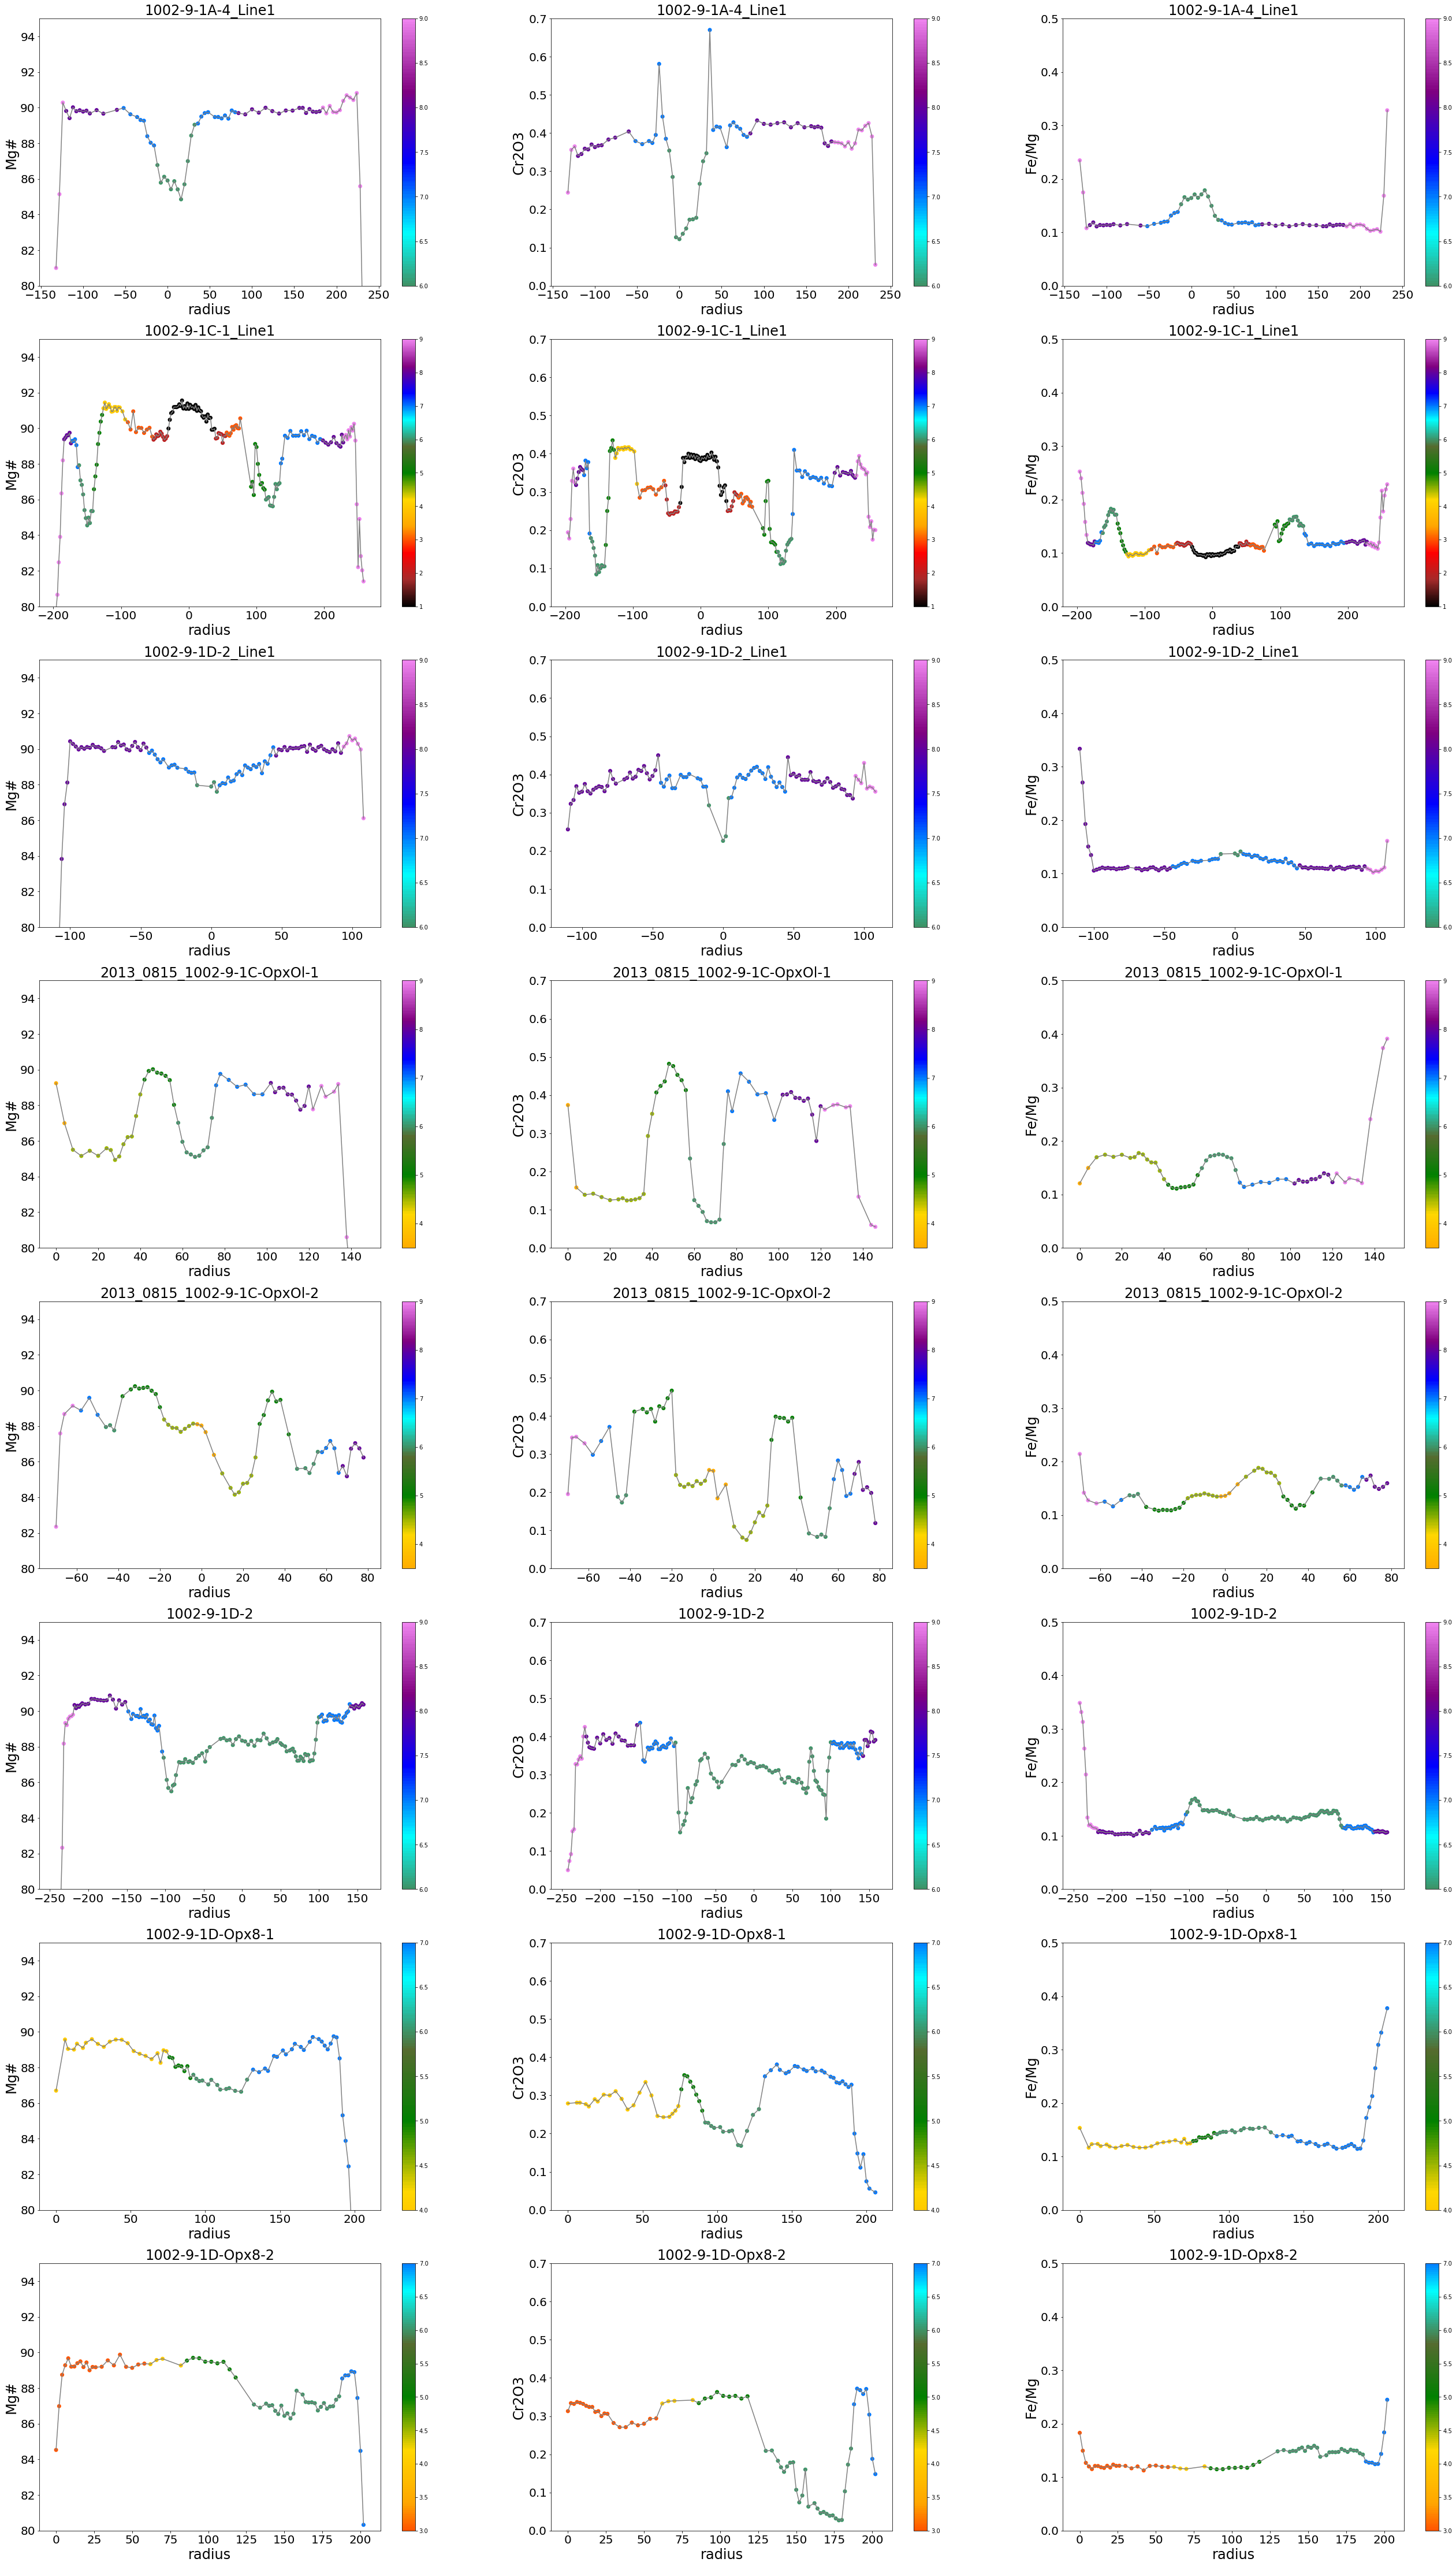

In [6]:
# Mg# と Cr2O3 プロファイルの描画
opx = getOpxs(df)


fig = plt.figure(figsize=(15*len(yName),10*sampleNum),facecolor="white")

i = 1
for grain in sample:
    data = opx[grain]
    
    for y in yName:
    
        ax=fig.add_subplot(sampleNum,len(yName),i)
        ax.tick_params(labelsize=20)
        ax.set_title(grain,fontsize=24)
        ax.set_xlabel(xName,fontsize=24)
        ax.set_ylabel(y,fontsize=24)
        ax.set_ylim(plotRange[y])
        plt.plot(data[xName],data[y],color="gray")
        plt.scatter(data[xName],data[y],c=data.stage,cmap=colorMap)
        ax=plt.colorbar()
        ax.set_clim(stageRange)
        i=i+1




![](../data/SVB/mineral/FE-SEM/2013_1002_1002-9-1C/2013_1002_164.bmp)

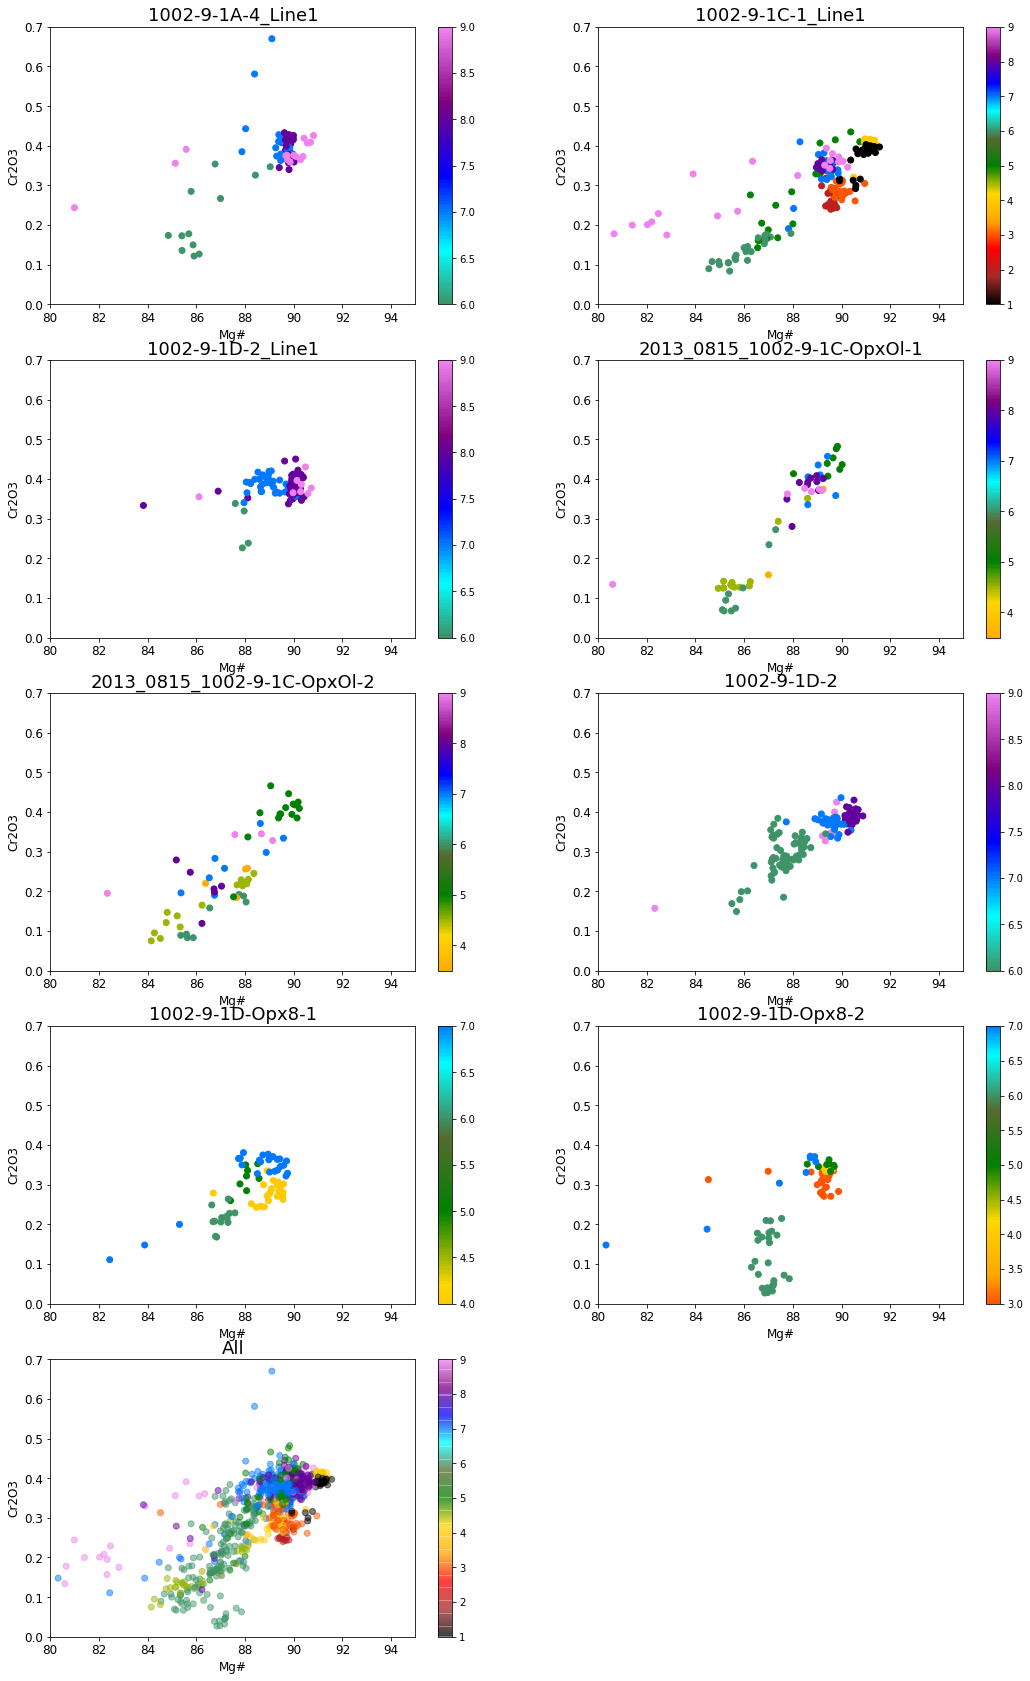

In [8]:
# Mg# と Cr2O3 プロファイルの描画
colorMap = gen_cmap(["black","brown","red","orange","gold","green","darkolivegreen","cyan","blue","purple","violet"])


stage = sorted(df.stage.unique())
stageRange=[min(stage),max(stage)]
stageNum = len(stage)

xName = "Mg#"
yName = ["Cr2O3"]

fig = plt.figure(figsize=(9*(len(yName)+1),6*sampleNum),facecolor="white")

i = 1
for grain in sample:
    data = opx[grain]
    
    for y in yName:
    
        ax=fig.add_subplot(sampleNum,len(yName)+1,i)
        ax.tick_params(labelsize=12)
        ax.set_title(grain,fontsize=18)
        ax.set_xlabel(xName,fontsize=12)
        ax.set_ylabel(y,fontsize=12)
        ax.set_xlim(plotRange[xName])
        ax.set_ylim(plotRange[y])
        plt.scatter(data[xName],data[y],c=data.stage,cmap=colorMap)
        ax=plt.colorbar()
        ax.set_clim(stageRange)
        i=i+1

## 全データ
ax=fig.add_subplot(sampleNum,len(yName)+1,i)
ax.tick_params(labelsize=12)
ax.set_title("All",fontsize=18)
ax.set_xlabel(xName,fontsize=12)
ax.set_ylabel(y,fontsize=12)
ax.set_xlim(plotRange[xName])
ax.set_ylim(plotRange[yName[0]])
plt.scatter(df[xName],df[yName[0]],c=df.stage,cmap=colorMap, alpha=0.5)
ax=plt.colorbar()
ax.set_clim(stageRange)


# 統合プロファイル

各粒子について,セクション幅で位置を規格化し，セクションごとに全ての粒子の組成プロファイルを統合する．

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


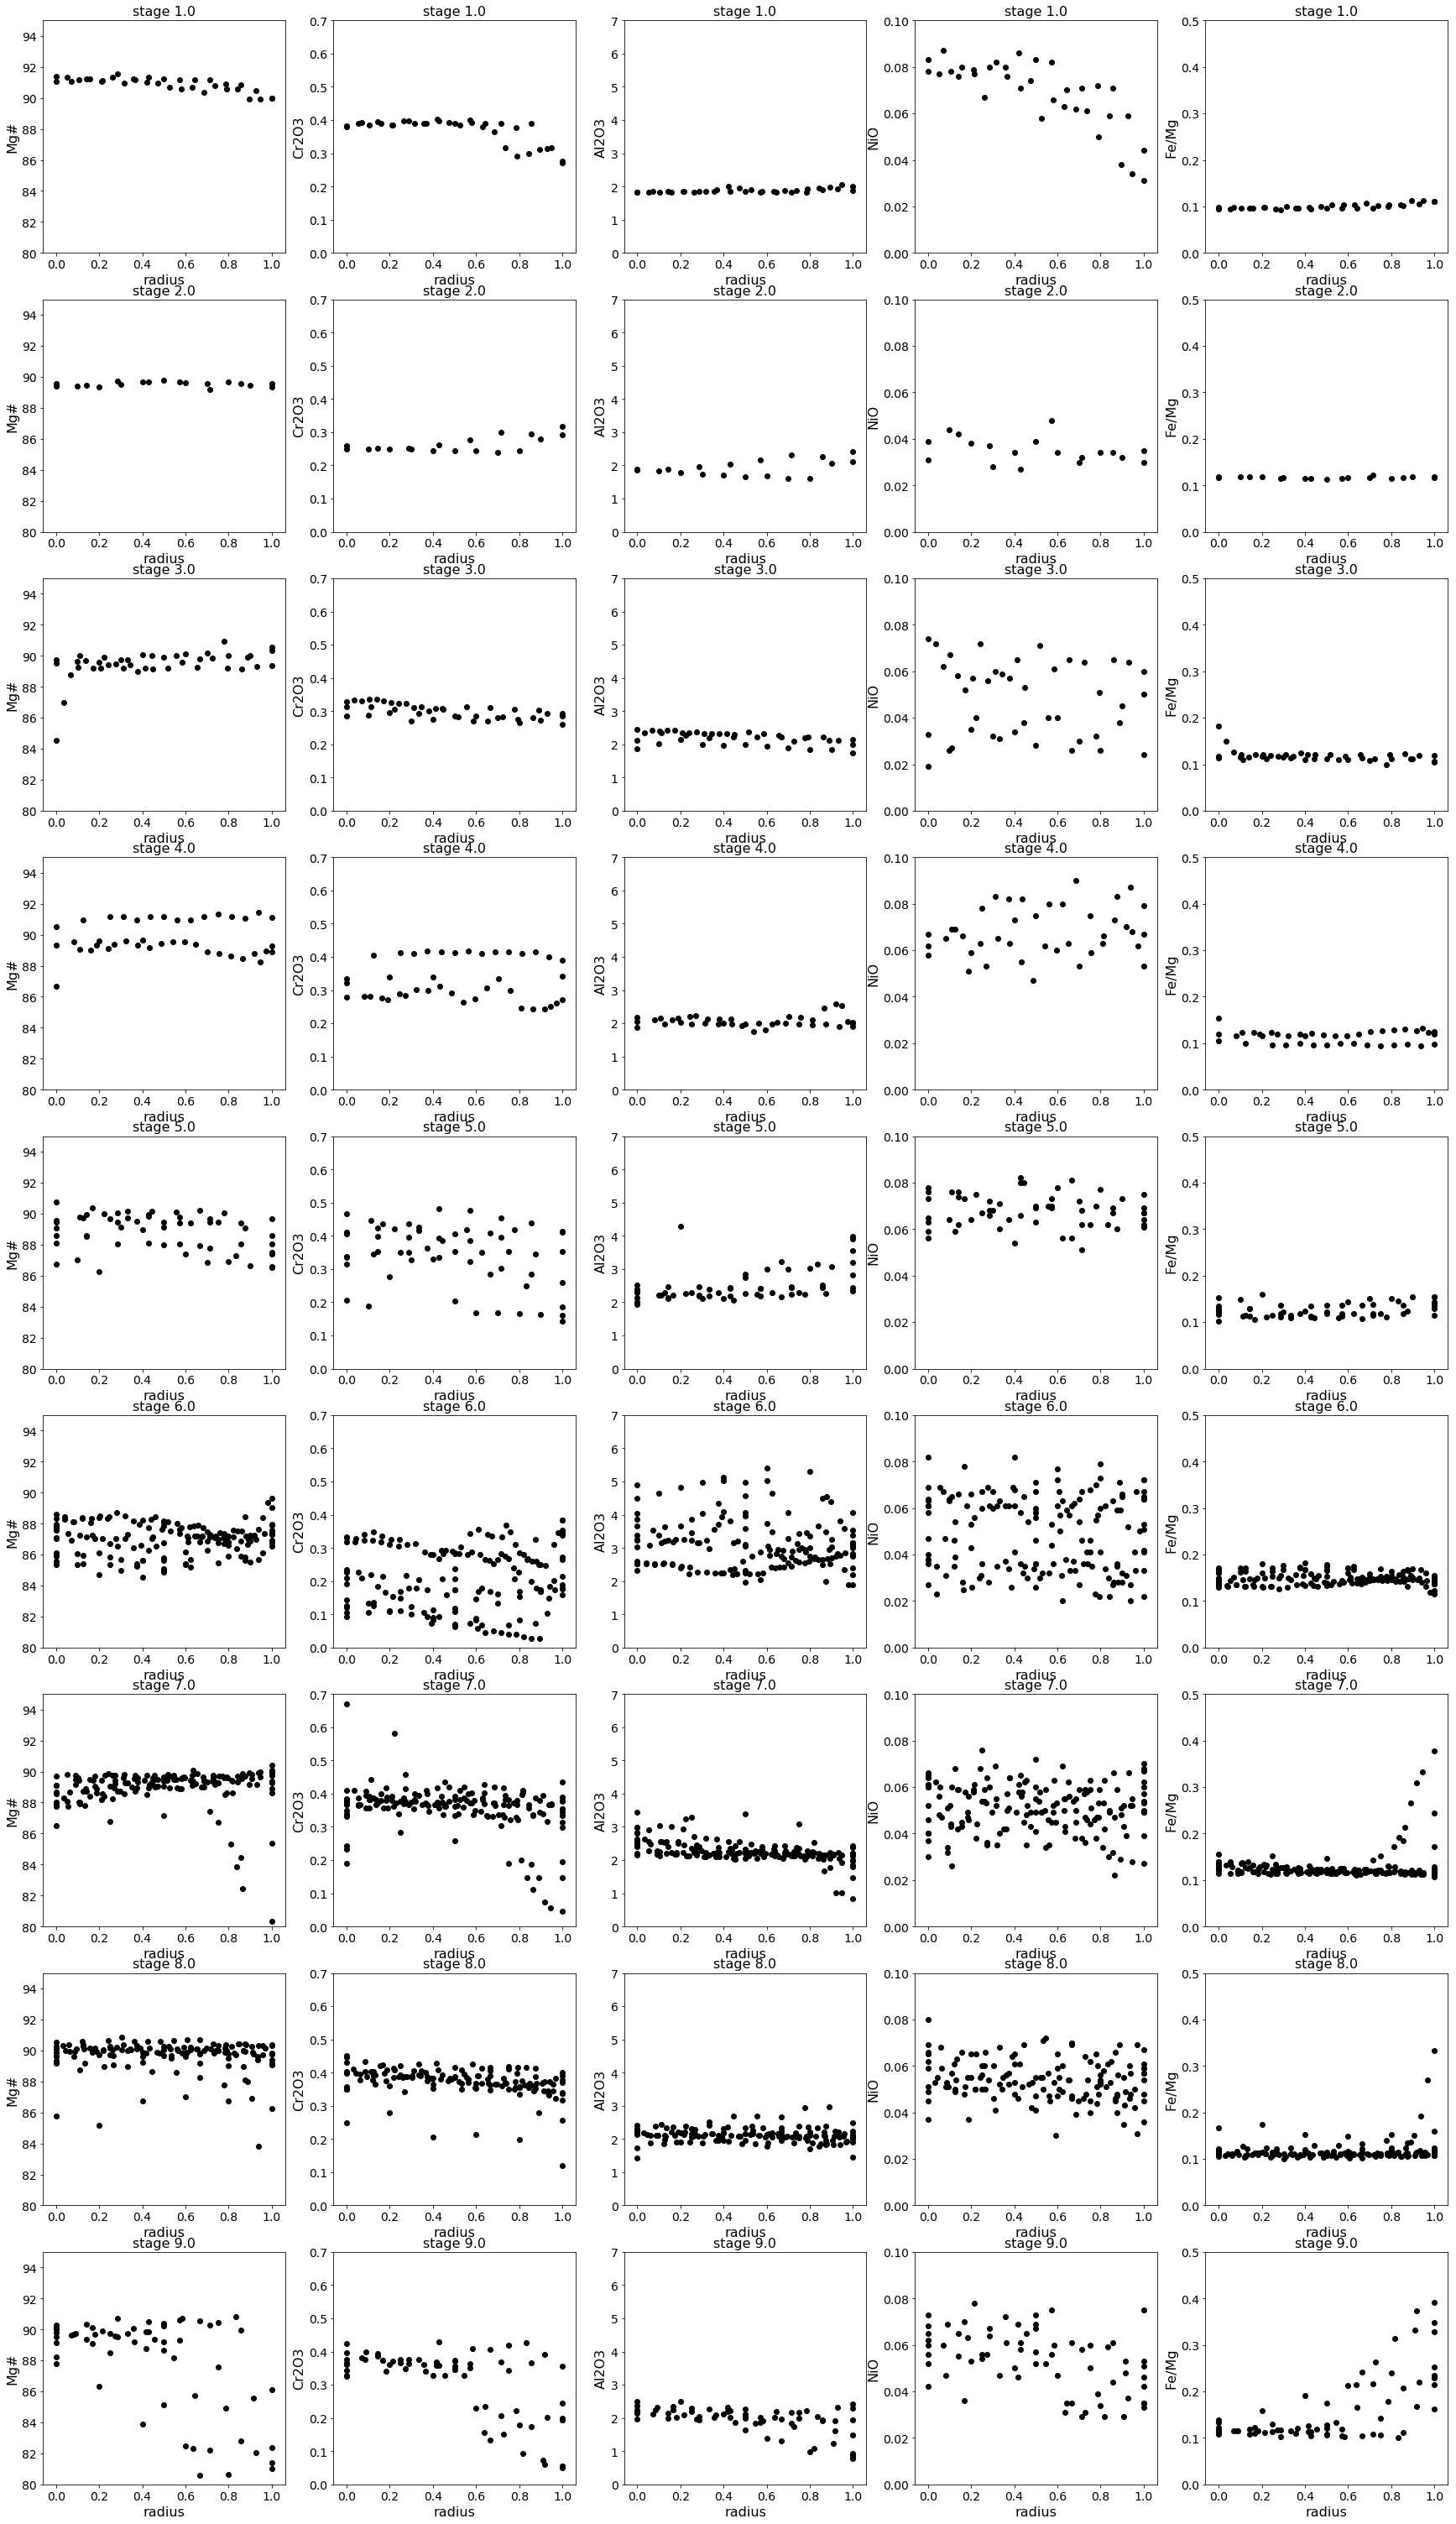

In [9]:
    
opx = getOpxs(df)
stage = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0]
yName = ["Mg#","Cr2O3","Al2O3","NiO","Fe/Mg"]
sample = ['1002-9-1A-4_Line1', '1002-9-1C-1_Line1', '1002-9-1D-2_Line1',
 '2013_0815_1002-9-1C-OpxOl-1', '2013_0815_1002-9-1C-OpxOl-2', '1002-9-1D-2',
 '1002-9-1D-Opx8-1', '1002-9-1D-Opx8-2'] 


normSectionAll = getNormSection(opx,sample,stage,yName)

In [34]:
print(normSectionAll["1.0"]["cordinate"])

['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l']


In [10]:

stage = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0]

num =0
for st in stage:
    data = normSectionAll[str(st)]
    num = num + len(data["Fe/Mg"])
    print(st,len(data["radius"]),len(data["Fe/Mg"]))
    print(min(data["radius"]),max(data["radius"]))

print(num)

1.0 35 35
0.0 1.0
2.0 19 19
0.0 1.0
3.0 43 43
0.0 1.0
4.0 41 41
-0.0 1.0
5.0 59 59
0.0 1.0
6.0 158 158
0.0 1.0
7.0 166 166
0.0 1.0
8.0 143 143
0.0 1.0
9.0 69 69
0.0 1.0
733


ステージごとに，半径の変化でプロファイルを規格化した．

Rayleigh 分別トレンドを仮定してモデル曲線にフィッテイングし，分散を求めればそれをMCMCにおける不確かさに用いることができる．

実際にMCMCに用いるときには，規格化された各ステージのプロファイルを実際の成長幅に合わせて伸縮し，必要なステージを組み合わせることでモデルプロファイルとする．

フィッティング曲線の周囲の分散はどうやって求めるか？
- 平均値が半径に依存する
  - 曲線を適当な関数としてフィッティング
  - 半径方向にいくつかの区間に区切り，そのなかでの平均を用いる
  - 移動平均

# 統合プロファイルの移動平均と分散

移動平均: 規格化されたセクション区間[0,1]を20分割し，21個のグリッド点の前後0.1の間のデータの平均と不偏分散を計算する

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


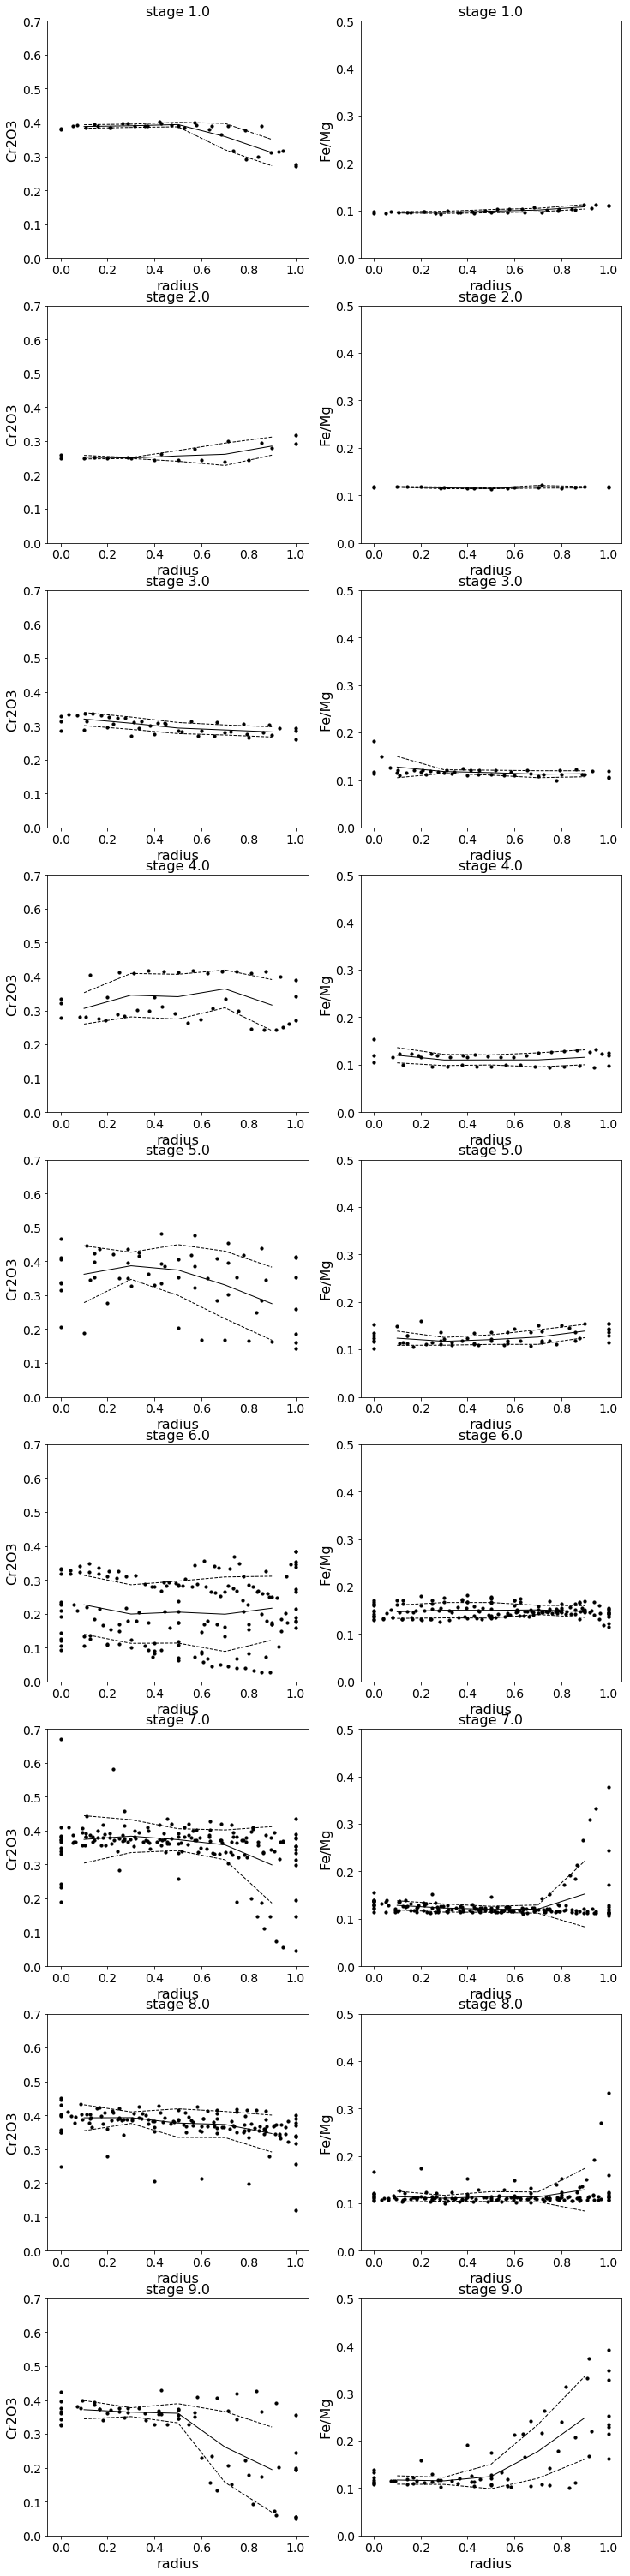

In [12]:

stage = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0]
yName = ["Cr2O3","Fe/Mg"]
result = moval(normSectionAll,stage,yName)

In [13]:
stdev = result["stdev"]
print(stdev)

{'1.0': {'Cr2O3': array([ 0.00522357,  0.00479086,  0.00661888,  0.03891382,  0.03888199]), 'Fe/Mg': array([ 0.00134572,  0.00226335,  0.00337284,  0.0037149 ,  0.00471293]), 'radius': array([ 0.1,  0.3,  0.5,  0.7,  0.9])}, '2.0': {'Cr2O3': array([ 0.00525991,  0.00141421,  0.01579821,  0.03296968,  0.02667771]), 'Fe/Mg': array([ 0.00078717,  0.00188288,  0.00075551,  0.00286404,  0.00149124]), 'radius': array([ 0.1,  0.3,  0.5,  0.7,  0.9])}, '3.0': {'Cr2O3': array([ 0.01937237,  0.01817355,  0.01638597,  0.01487568,  0.01507541]), 'Fe/Mg': array([ 0.02242871,  0.00374062,  0.00512582,  0.00733496,  0.00626786]), 'radius': array([ 0.1,  0.3,  0.5,  0.7,  0.9])}, '4.0': {'Cr2O3': array([ 0.04628927,  0.0640948 ,  0.06607125,  0.05566926,  0.0752575 ]), 'Fe/Mg': array([ 0.01603901,  0.01173604,  0.01059685,  0.0147729 ,  0.01567855]), 'radius': array([ 0.1,  0.3,  0.5,  0.7,  0.9])}, '5.0': {'Cr2O3': array([ 0.08387553,  0.0399531 ,  0.07482687,  0.09965139,  0.10776012]), 'Fe/Mg': arr

# 実際の粒子のステージ幅に合わせて統合プロファイルを変形
## 1002-9-1C-1のセグメントに合わせた全てのデータ点

stage4以前はデータが少ないため，不確かさが過小に見積もられている．

In [14]:
print(sample)

['1002-9-1A-4_Line1', '1002-9-1C-1_Line1', '1002-9-1D-2_Line1', '2013_0815_1002-9-1C-OpxOl-1', '2013_0815_1002-9-1C-OpxOl-2', '1002-9-1D-2', '1002-9-1D-Opx8-1', '1002-9-1D-Opx8-2']


Fe/Mg 733
Cr2O3 733
733 733.0


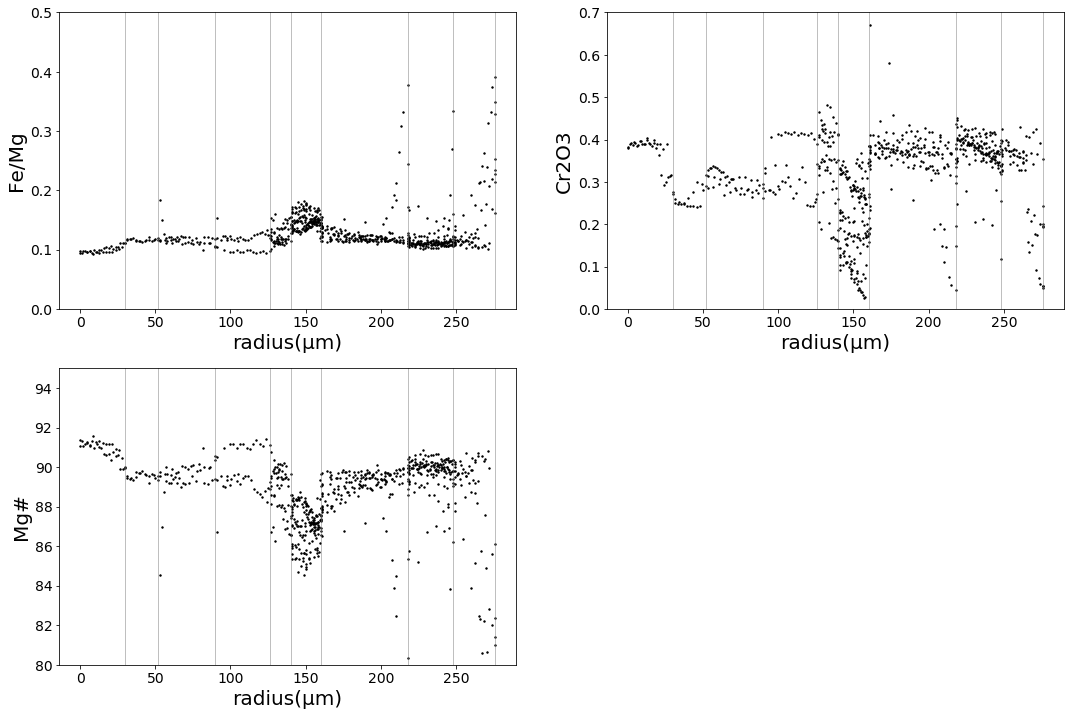

In [15]:

# ステージ5まではステージ幅としてleft側の値を用いる
title = "1002-9-1C-1_line1"
stageRadius = [30,52,90,126,140,160,218,248,276]
stage = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0]
yName = ["Fe/Mg","Cr2O3"]

data = getDataForInversion(normSectionAll,yName,stage,stageRadius,stdev,err=False)

# 統合プロファイルと各データ点の標準偏差を出力
## all data

df_grain=pd.DataFrame({
    "x":data["radius"]*1e-6,
    "Fe_Mg":data["Fe/Mg"],
    "Cr2O3":data["Cr2O3"]
})

df_error = pd.DataFrame({
    "x":data["radius"]*1e-6,
    "Fe_Mg":data["Fe/Mg_stdev"],
    "Cr2O3":data["Cr2O3_stdev"]
})

print(df_grain,df_error)
df_grain.to_csv("z:/integlated_profile.csv")
df_error.to_csv("z:/integrated_profile_err.csv")

## 1002-9-1C-1に対し, 移動平均に対する標準誤差を不確かさとする

In [21]:
## 標準誤差の計算


stage = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0]
yName = ["Cr2O3","Fe/Mg"]
integratedStdev = integratedMoval(normSectionAll,stage,yName)["stdev"]

print(integratedStdev)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
{'Cr2O3': 0.06791586740113284, 'Fe/Mg': 0.025803512116140653}


[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
Fe/Mg 188
Cr2O3 188
     Cr2O3     Fe_Mg         x
0    0.381  0.097807  0.000000
1    0.390  0.095115  0.000002
2    0.386  0.096943  0.000003
3    0.391  0.096336  0.000005
4    0.385  0.097915  0.000006
5    0.397  0.095177  0.000008
6    0.389  0.099135  0.000009
7    0.390  0.096827  0.000011
8    0.403  0.098863  0.000013
9    0.393  0.099441  0.000014
10   0.384  0.102679  0.000016
11   0.392  0.103839  0.000017
12   0.380  0.102932  0.000019
13   0.364  0.106483  0.000021
14   0.316  0.101689  0.000022
15   0.292  0.104063  0.000024
16   0.300  0.103890  0.000025
17   0.312  0.112111  0.000027
18   0.317  0.112079  0.000028
19   0.276  0.111451  0.000030
20   0.271  0.111292  0.000030
21   0.313  0.105250  0.000028
22   0.389  0.100746  0.000026
23   0.378  0.100032  0.000024
24   0.390  0.096644  0.000021
25   0.390  0.096581  0.000019
26   0.400  0.096664  0.000017
27   0.389  0.096227  0.000015
28   0.398  0.094759  0.000013
29  

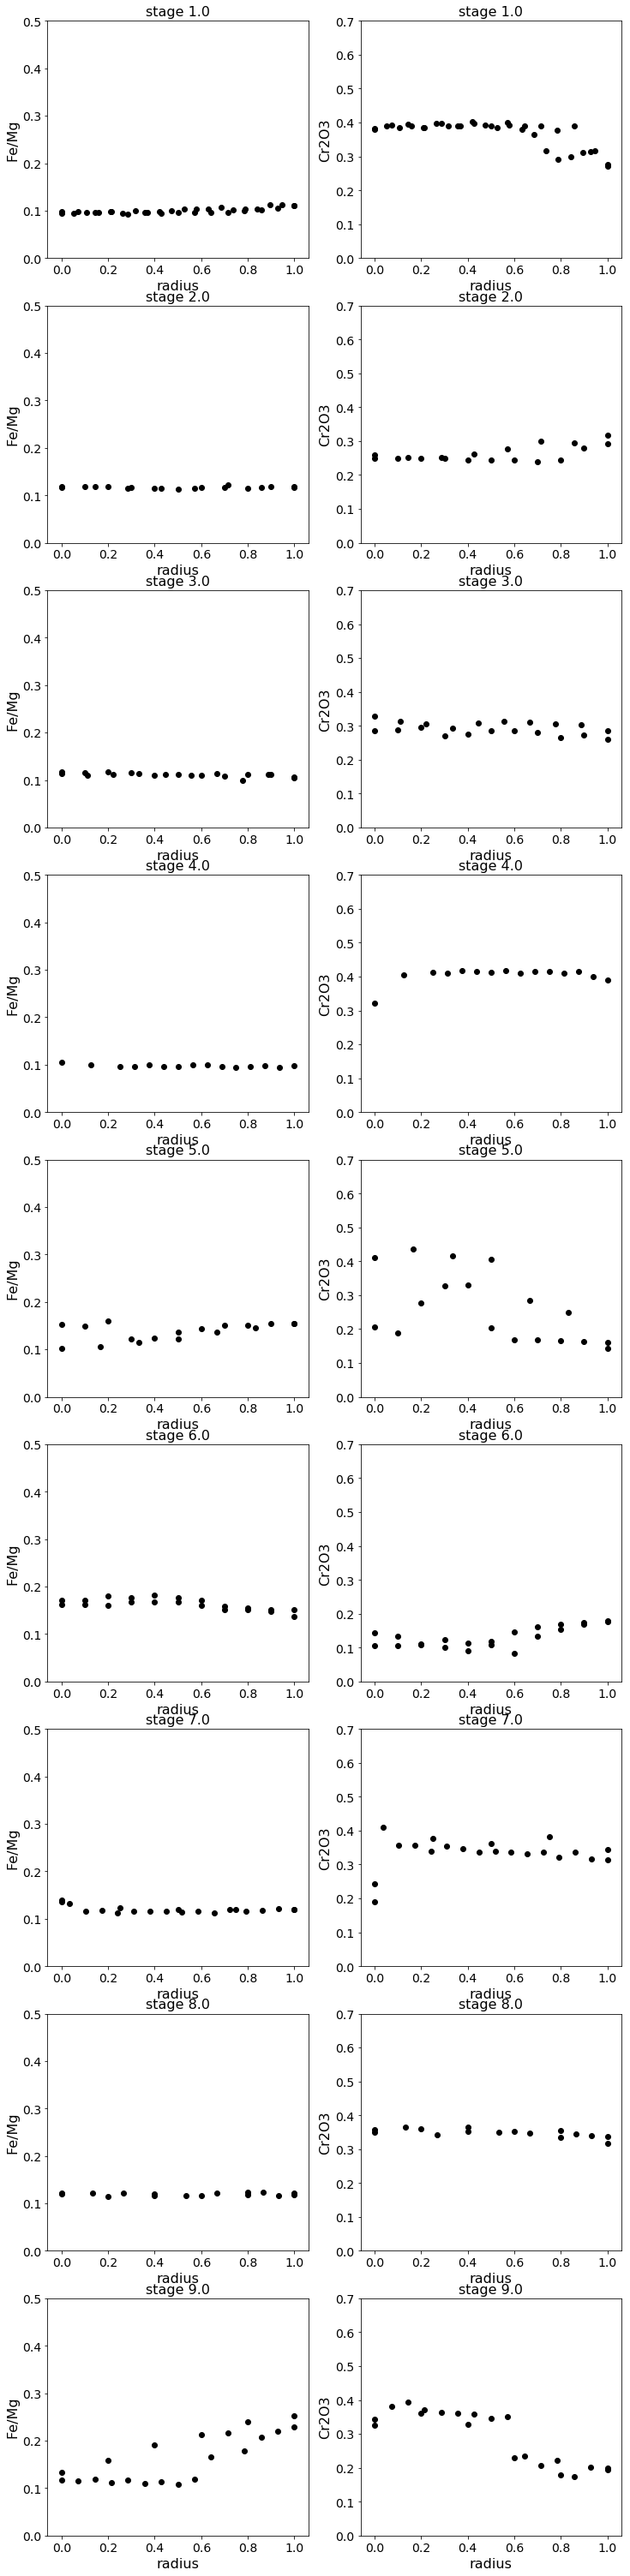

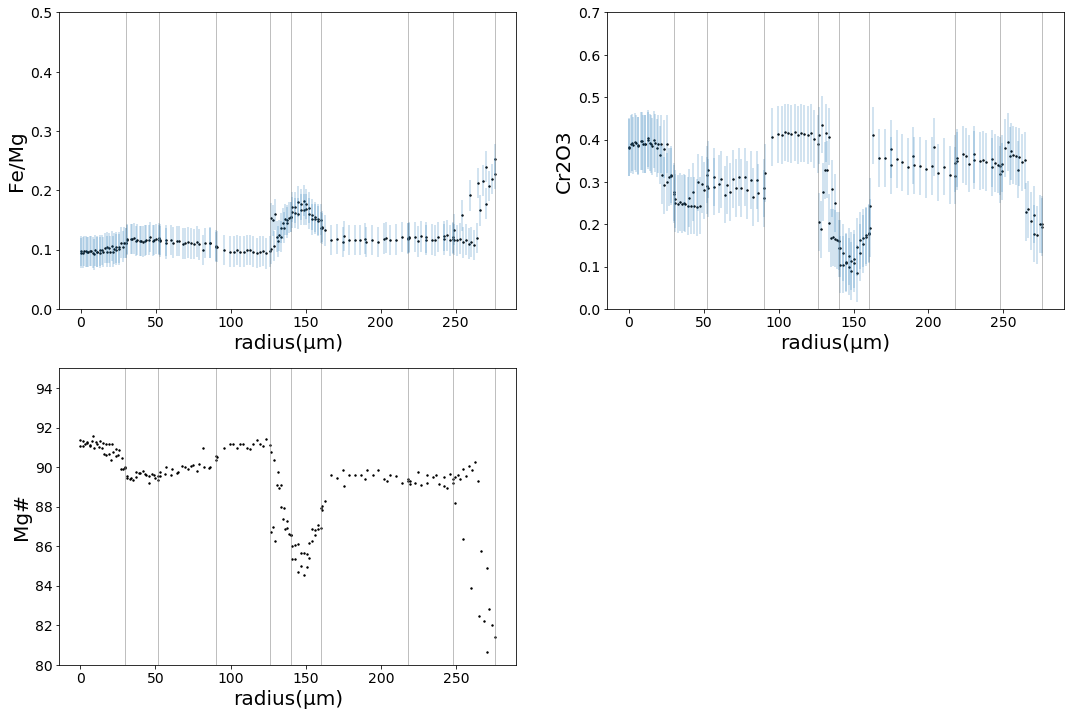

In [72]:
## 1002-9-1C のみ
stageRadius = [30,52,90,126,140,160,218,248,276]
stage = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0]
yName = ["Fe/Mg","Cr2O3"]
sample = ['1002-9-1C-1_Line1'] 

normSection = getNormSection(opx,sample,stage,yName)
#data = getDataForInversion(normSection,yName,stage,stageRadius,stdev)
data = getDataForInversion2(normSection,yName,stage,stageRadius,integratedStdev)

df_grain=pd.DataFrame({
    "x":data["radius"]*1e-6,
    "Fe_Mg":data["Fe/Mg"],
    "Cr2O3":data["Cr2O3"]
})

df_error = pd.DataFrame({
    "x":data["radius"]*1e-6,
    "Fe_Mg":data["Fe/Mg_stdev"],
    "Cr2O3":data["Cr2O3_stdev"]
})

print(df_grain,df_error)
df_grain.to_csv("z:/1002-9-1_integrated.csv")
df_error.to_csv("z:/1002-9-1_integrated_err.csv")

## 1002-9-1D-2に標準誤差を不確かさとする

[6.0, 7.0, 8.0, 9.0]
Fe/Mg 145
Cr2O3 145
     Cr2O3     Fe_Mg         x
0    0.330  0.131955  0.000000
1    0.319  0.132544  0.000004
2    0.322  0.134866  0.000008
3    0.323  0.132177  0.000012
4    0.319  0.135733  0.000016
5    0.311  0.131467  0.000020
6    0.306  0.131755  0.000024
7    0.310  0.126940  0.000028
8    0.312  0.130332  0.000032
9    0.289  0.134367  0.000036
10   0.279  0.133256  0.000040
11   0.293  0.132531  0.000044
12   0.293  0.130863  0.000046
13   0.284  0.133854  0.000050
14   0.283  0.134989  0.000052
15   0.279  0.136085  0.000056
16   0.289  0.139736  0.000058
17   0.279  0.139097  0.000062
18   0.264  0.138505  0.000064
19   0.263  0.137757  0.000066
20   0.252  0.139999  0.000068
21   0.266  0.143416  0.000070
22   0.334  0.146611  0.000072
23   0.369  0.146530  0.000074
24   0.348  0.143649  0.000076
25   0.310  0.144894  0.000078
26   0.285  0.146822  0.000080
27   0.281  0.141711  0.000082
28   0.268  0.142499  0.000084
29   0.261  0.142296  0.00008

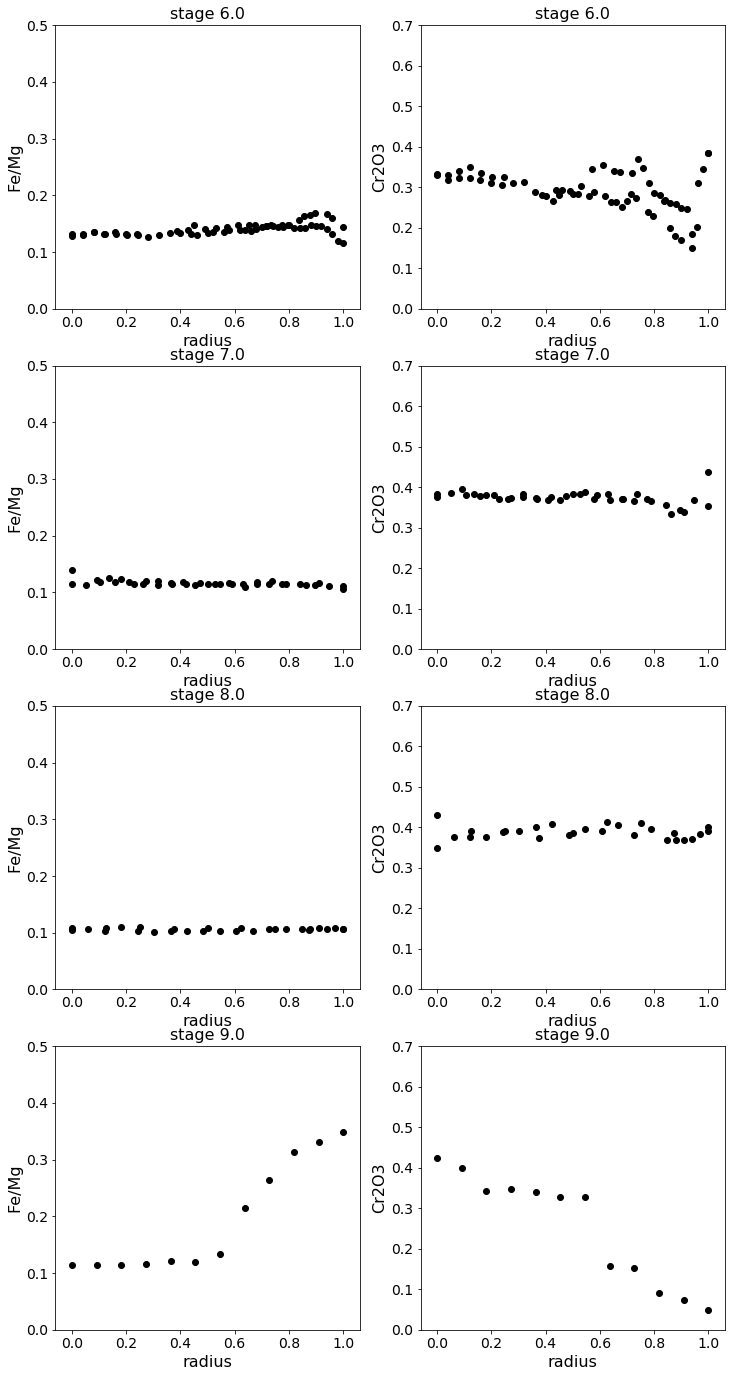

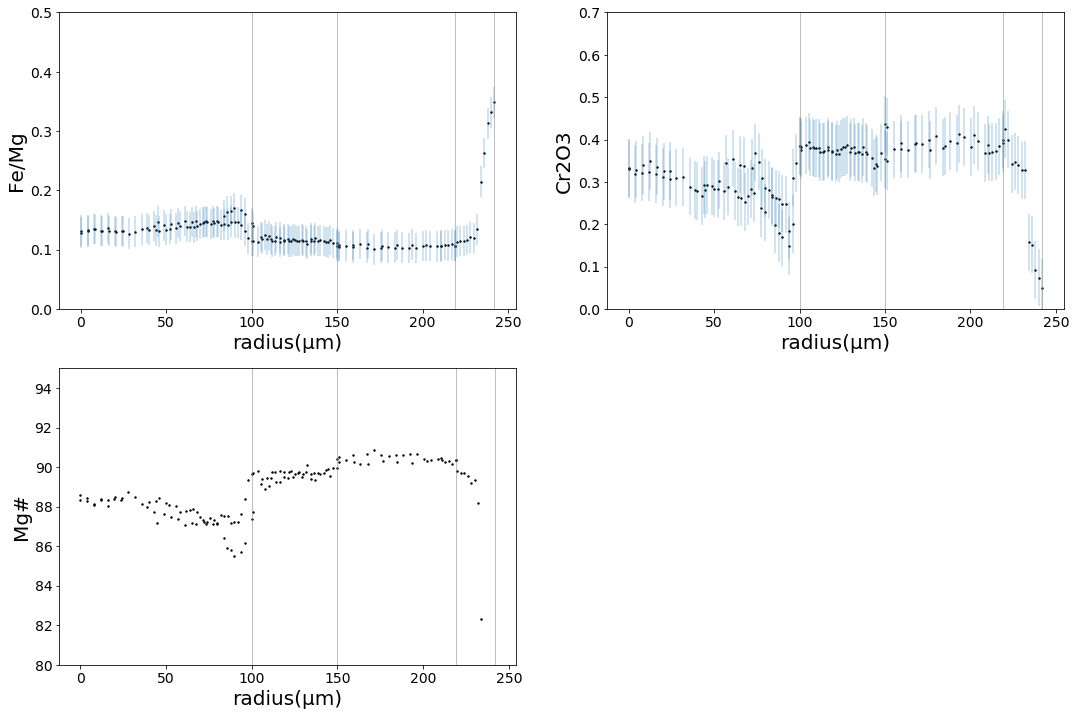

In [23]:
## 1002-9-1C のみ
stageRadius = [100,150,219,242]
stage =       [6.0,7.0,8.0,9.0]
yName = ["Fe/Mg","Cr2O3"]
sample = ['1002-9-1D-2'] 

normSection = getNormSection(opx,sample,stage,yName)
#data = getDataForInversion(normSection,yName,stage,stageRadius,stdev)
data = getDataForInversion2(normSection,yName,stage,stageRadius,integratedStdev)

df_grain=pd.DataFrame({
    "x":data["radius"]*1e-6,
    "Fe_Mg":data["Fe/Mg"],
    "Cr2O3":data["Cr2O3"]
})

df_error = pd.DataFrame({
    "x":data["radius"]*1e-6,
    "Fe_Mg":data["Fe/Mg_stdev"],
    "Cr2O3":data["Cr2O3_stdev"]
})

print(df_grain,df_error)
df_grain.to_csv("z:/1002-9-1D-2_integrated.csv")
df_error.to_csv("z:/1002-9-1D-2_integrated_err.csv")

In [ ]:
a=[1,4,2,5]
a=sorted(a)
print(a)

for v,i in zip(a,range(len(a))):
    print(v,i)
    
print( (-0.0 <= 0.5-1/2))